<a href="https://colab.research.google.com/github/VirunaVidaswin/Machine-Learning/blob/main/Machine_Learning_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Corpus Preparation**

## **1.1 Imports, Loading and Viewing the Dataset**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score

df = pd.read_csv('/content/bank-additional-full.csv', sep=';')
print(f"\nTotal Rows: {df.shape[0]}")
print(f"Total Cols: {df.shape[1]}")
print("\nDataset Head:")
print(df.head())




Total Rows: 41188
Total Cols: 21

Dataset Head:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons

## **2.1 Categorical Feature Overview**

In [11]:
for column in df.select_dtypes('object'):
    print(f"\nColumn: {column} , "+f" Values: {df[column].unique()}")


Column: job ,  Values: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Column: marital ,  Values: ['married' 'single' 'divorced' 'unknown']

Column: education ,  Values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Column: default ,  Values: ['no' 'unknown' 'yes']

Column: housing ,  Values: ['no' 'yes' 'unknown']

Column: loan ,  Values: ['no' 'yes' 'unknown']

Column: contact ,  Values: ['telephone' 'cellular']

Column: month ,  Values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Column: day_of_week ,  Values: ['mon' 'tue' 'wed' 'thu' 'fri']

Column: poutcome ,  Values: ['nonexistent' 'failure' 'success']

Column: y ,  Values: ['no' 'yes']


## **3.1 Numerical Feature Overview**

In [12]:
num_features = df.select_dtypes(include=[np.number])
print(num_features.head())


   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  
0          -36.4      4.857       5191.0  
1          -36.4      4.857       5191.0  
2          -36.4      4.857       5191.0  
3          -36.4      4.857       5191.0  
4          -36.4      4.857       5191.0  


## **4.1 Data Preprocessing**

**4.1.1 Finding any missing values**

In [13]:
missing_values = df.isnull().sum()
print(missing_values)


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


**4.1.2 Checking for duplicate rows**

In [14]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 12


In [15]:
df = df.drop_duplicates()
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows after dropping : {num_duplicates}")

Number of duplicate rows after dropping : 0


**4.1.3 Inconsistent in dataset handling**

In [16]:
df.loc[:, 'pdays'] = df['pdays'].replace(999, -1)
df.loc[(df['pdays'] == -1) & (df['previous'] != 0), 'previous'] = 0
# Drop rows where duration equals to 0 because it has too much predictive power
df = df[df['duration']!=0]


## **5.1 Outlier Handling**

**5.1.1 Handling Numerical features outliers**

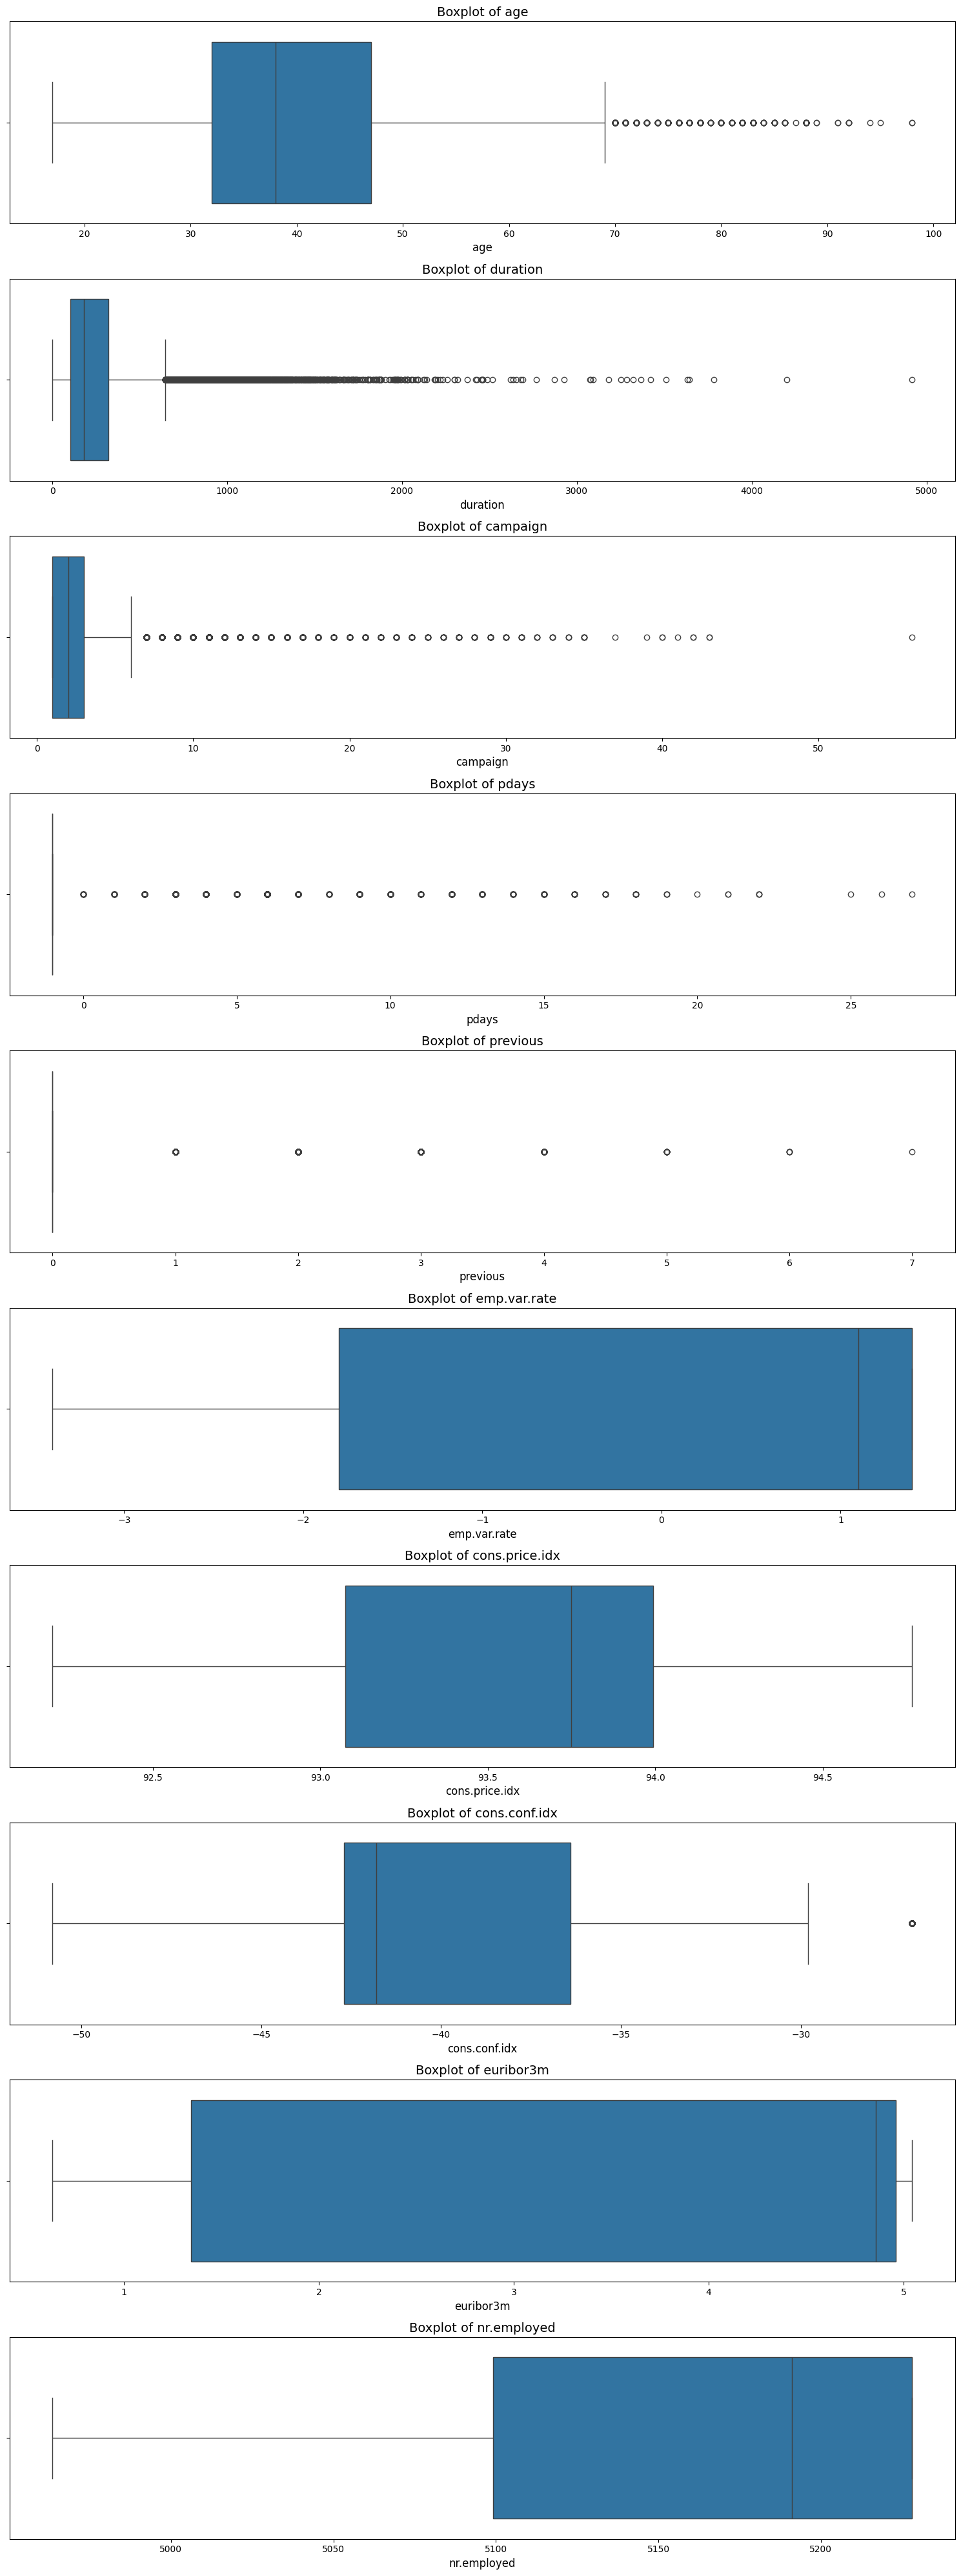

In [17]:
num_features = df.select_dtypes(include=[np.number])
Q1 = num_features.quantile(0.25)
Q3 = num_features.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((num_features < (Q1 - 1.5 * IQR)) | (num_features > (Q3 + 1.5 * IQR))).any(axis=1)

outlier_counts = {}
for col in num_features.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    outliers = num_features[(num_features[col] < lower_bound) | (num_features[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

plt.figure(figsize=(15, len(num_features.columns) * 4))  # Adjust figure size based on the number of features
for i, col in enumerate(num_features.columns):
    plt.subplot(len(num_features.columns), 1, i + 1)  # Create a separate subplot for each feature
    sns.boxplot(x=num_features[col])
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [18]:
# Checking for outliers
df.groupby(['y','previous'],sort=True)['previous'].count()

y    previous
no   0           35985
     1             349
     2             124
     3              47
     4              23
     5               3
     6               1
     7               1
yes  0            3672
     1             516
     2             281
     3             119
     4              35
     5              13
     6               3
Name: previous, dtype: int64

In [19]:
# Checking for outliers
df.groupby(['y','campaign'],sort=True)['campaign'].count()

y    campaign
no   1           15335
     2            9356
     3            4765
     4            2400
     5            1479
     6             904
     7             591
     8             383
     9             266
     10            212
     11            165
     12            122
     13             88
     14             68
     15             49
     16             51
     17             54
     18             33
     19             26
     20             30
     21             24
     22             17
     23             15
     24             15
     25              8
     26              8
     27             11
     28              8
     29             10
     30              7
     31              7
     32              4
     33              4
     34              3
     35              5
     37              1
     39              1
     40              2
     41              1
     42              2
     43              2
     56              1
yes  1            2299
     2            1211
     3             574
     4             249
     5             120
     6              75
     7              38
     8              17
     9              17
     10             12
     11             12
     12              3
     13              4
     14              1
     15              2
     17              4
     23              1
Name: campaign, dtype: int64

In [20]:
# Checking for outliers
df.groupby(['y','pdays'],sort=True)['pdays'].count()

y    pdays
no   -1       35985
      0           5
      1          18
      2          24
      3         141
      4          55
      5          17
      6         123
      7          20
      8           6
      9          29
      10         22
      11         13
      12         32
      13          8
      14          9
      15          8
      16          5
      17          6
      18          3
      19          2
      20          1
      22          1
yes  -1        3672
      0          10
      1           8
      2          37
      3         298
      4          63
      5          29
      6         289
      7          40
      8          12
      9          35
      10         30
      11         15
      12         26
      13         28
      14         11
      15         16
      16          6
      17          2
      18          4
      19          1
      21          2
      22          2
      25          1
      26          1
      27          1
Name: pdays, dtype: int64

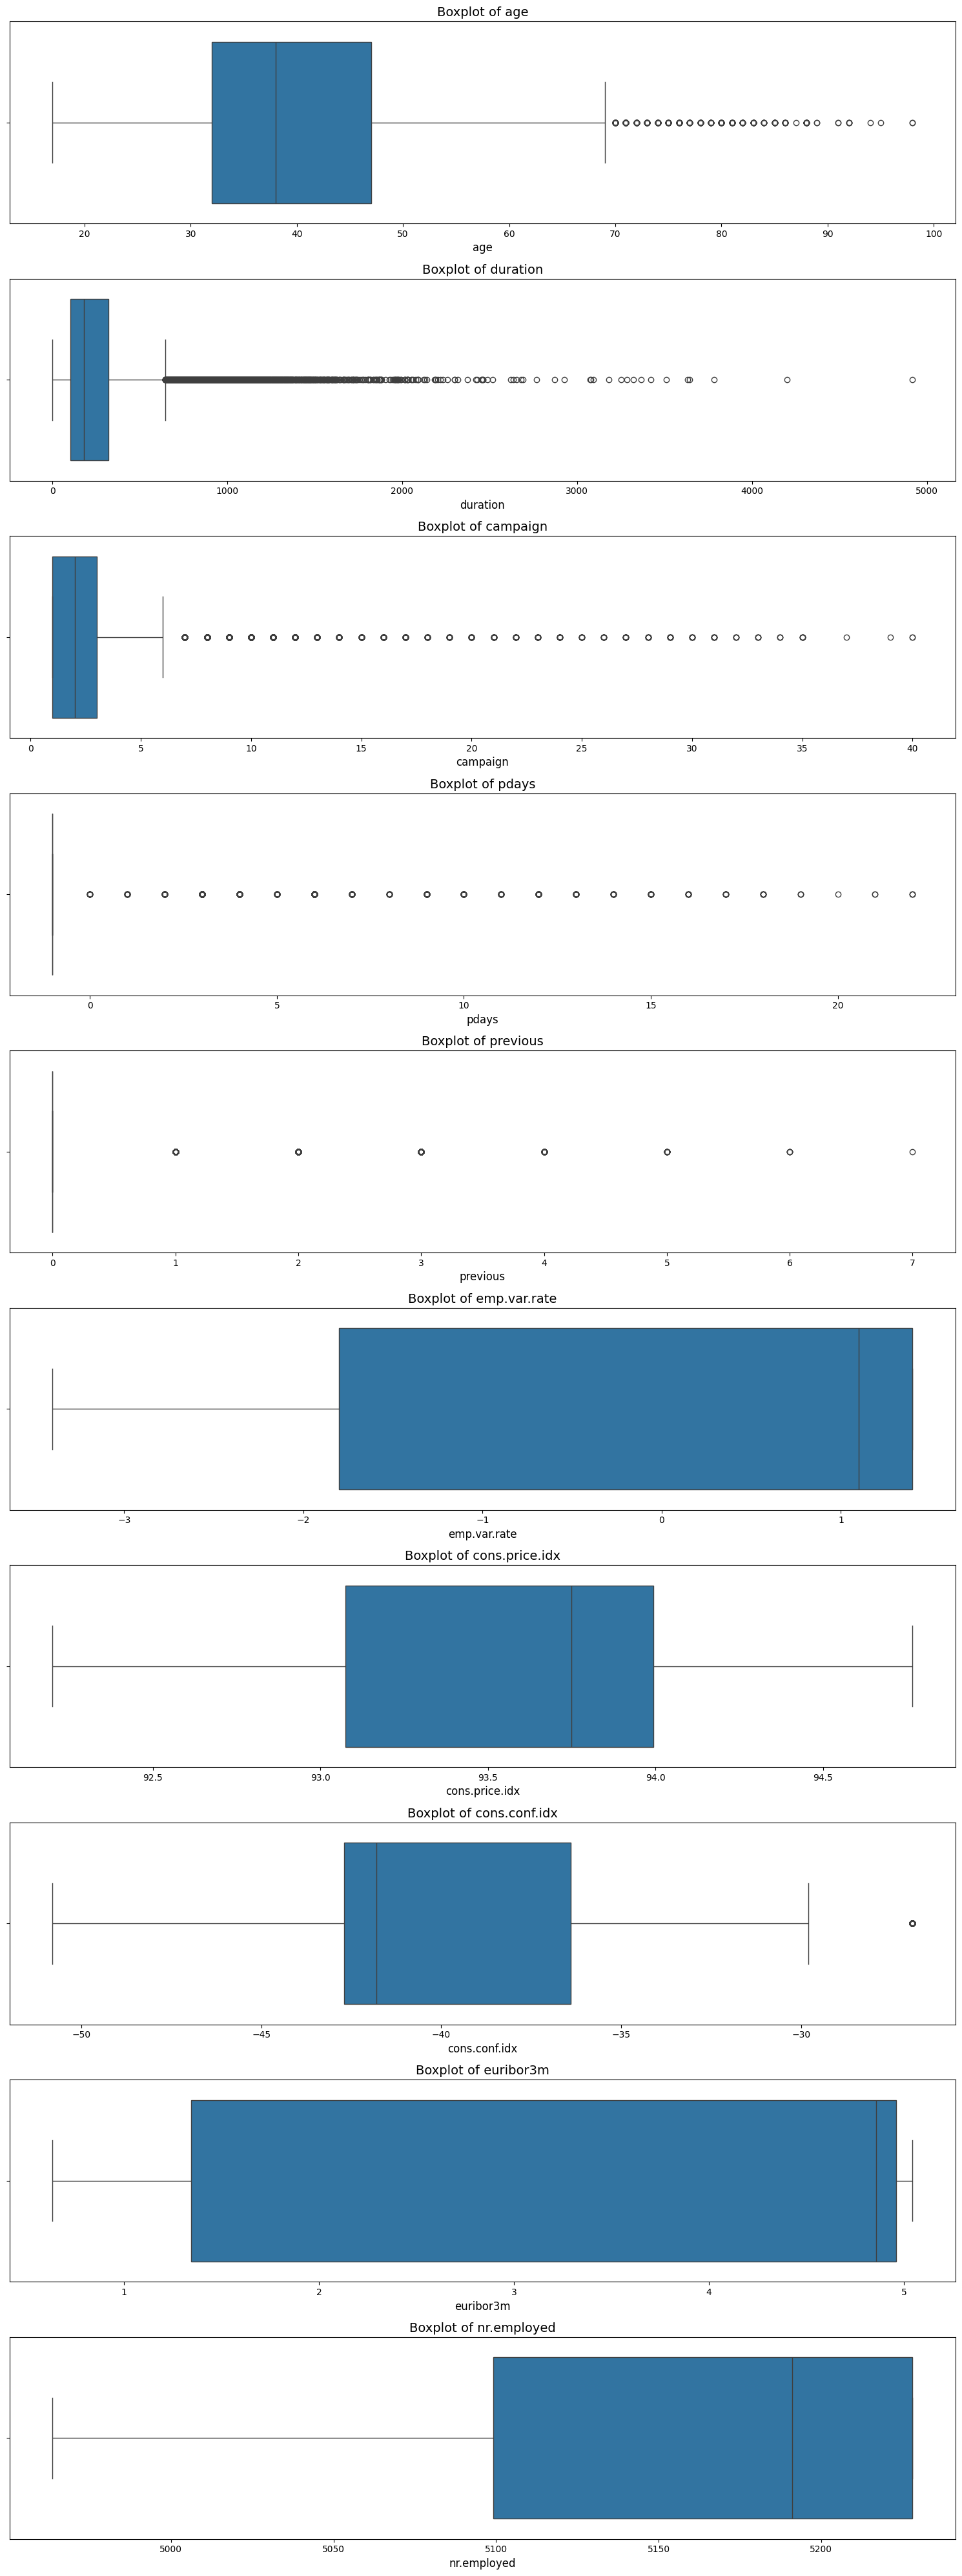

In [21]:
df2 = df[(df['campaign'] < 41) & (df['pdays'] < 25)].copy()
# After removing outliers from campaign
num_features = df2.select_dtypes(include=[np.number])
Q1 = num_features.quantile(0.25)
Q3 = num_features.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((num_features < (Q1 - 1.5 * IQR)) | (num_features > (Q3 + 1.5 * IQR))).any(axis=1)

outlier_counts = {}
for col in num_features.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    outliers = num_features[(num_features[col] < lower_bound) | (num_features[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

plt.figure(figsize=(15, len(num_features.columns) * 4))  # Adjust figure size based on the number of features
for i, col in enumerate(num_features.columns):
    plt.subplot(len(num_features.columns), 1, i + 1)  # Create a separate subplot for each feature
    sns.boxplot(x=num_features[col])
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [22]:
# After removing outliers from pdays
df2.groupby(['y','pdays'],sort=True)['pdays'].count()

y    pdays
no   -1       35979
      0           5
      1          18
      2          24
      3         141
      4          55
      5          17
      6         123
      7          20
      8           6
      9          29
      10         22
      11         13
      12         32
      13          8
      14          9
      15          8
      16          5
      17          6
      18          3
      19          2
      20          1
      22          1
yes  -1        3672
      0          10
      1           8
      2          37
      3         298
      4          63
      5          29
      6         289
      7          40
      8          12
      9          35
      10         30
      11         15
      12         26
      13         28
      14         11
      15         16
      16          6
      17          2
      18          4
      19          1
      21          2
      22          2
Name: pdays, dtype: int64

## **6.1 Checking for data imbalancing**

     Count  Percentage
y                     
no   36527   88.737458
yes   4636   11.262542


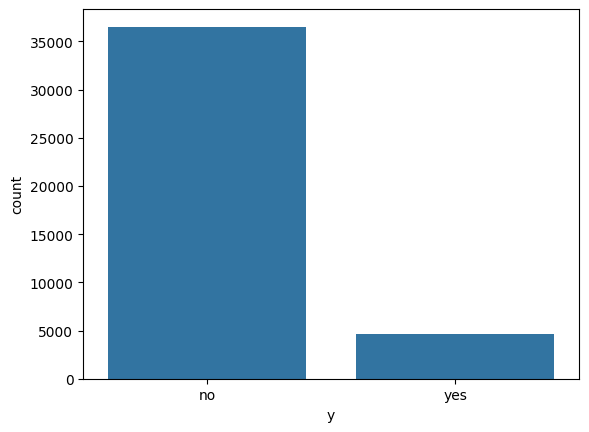

In [23]:
counts = df2.groupby('y', sort=True)['y'].count()
percentages = (counts / counts.sum()) * 100
result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
print(result)

sns.countplot(x='y', data=df2)
plt.show()

## **7.1 Feature Training**

In [24]:
cat_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
bool_features = ['housing', 'loan', 'y', 'default']

# Encode categorical features
df3_cat_encoded = pd.get_dummies(df2[cat_features], drop_first=True)
df3_cat_encoded = df3_cat_encoded.astype(int)

# Handle boolean features
df2[bool_features] = df2[bool_features].apply(lambda col: col.map(lambda x: x if x in ['yes', 'no'] else 'no'))
df3_bool_encoded = df2[bool_features].apply(lambda col: col.map({'yes': 1, 'no': 0}))
df3_bool_encoded = df3_bool_encoded.astype(int)

# Drop original features and concatenate encoded data
df3 = df2.drop(columns=cat_features + bool_features)
df3 = pd.concat([df3, df3_cat_encoded, df3_bool_encoded], axis=1)

print(df3.head())


   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1     -1         0           1.1          93.994   
1   57       149         1     -1         0           1.1          93.994   
2   37       226         1     -1         0           1.1          93.994   
3   40       151         1     -1         0           1.1          93.994   
4   56       307         1     -1         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  ...  day_of_week_mon  \
0          -36.4      4.857       5191.0  ...                1   
1          -36.4      4.857       5191.0  ...                1   
2          -36.4      4.857       5191.0  ...                1   
3          -36.4      4.857       5191.0  ...                1   
4          -36.4      4.857       5191.0  ...                1   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  poutcome_nonexistent  \
0                0                0                0          

# **2. Test and Train**

In [43]:
X = df3.drop('y', axis=1)
y = df3['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

y_train = y_train.squeeze()
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class Distribution After SMOTE:
y
0    25569
1    25569
Name: count, dtype: int64


1 Random Forest

In [54]:
# Random Forest Model
print("\n--- Random Forest Classifier ---\n")
rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    n_estimators=100,
    class_weight='balanced'
)
rf_model.fit(X_train_sc, y_train)


# Random Forest Predictions
rf_predictions = rf_model.predict(X_test_sc)

# Random Forest Evaluation
print("Classification Report:")
print(classification_report(y_test, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))





--- Random Forest Classifier ---

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10958
           1       0.55      0.80      0.65      1391

    accuracy                           0.90     12349
   macro avg       0.76      0.86      0.80     12349
weighted avg       0.92      0.90      0.91     12349

Confusion Matrix:
[[10039   919]
 [  285  1106]]


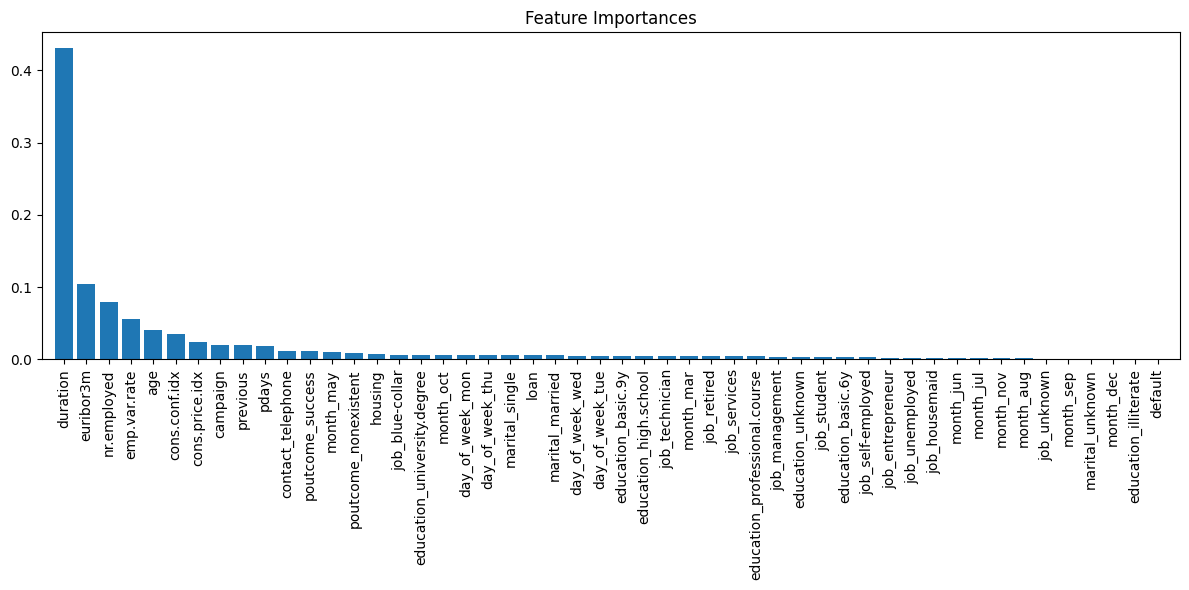

In [55]:
#feature importance

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_resampled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns[indices], rotation=90)
plt.xlim([-1, X_train_resampled.shape[1]])
plt.tight_layout()
plt.show()


2. Neural Network

In [61]:
# Building the model

nn_model = Sequential([
    # Input Layer
    Dense(64, input_dim=X_train_sc.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Additional Hidden Layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    # Output Layer
    Dense(1, activation='sigmoid')  # Binary classification
])


# Compiling the model

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,          # Number of epochs to wait for improvement
                               restore_best_weights=True, # Restore the model to the best weights
                               verbose=1)


Nn = nn_model.fit(X_train_sc, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])


Epoch 1/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7421 - loss: 0.5578 - val_accuracy: 0.8981 - val_loss: 0.2376
Epoch 2/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8908 - loss: 0.2711 - val_accuracy: 0.9028 - val_loss: 0.2098
Epoch 3/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8977 - loss: 0.2339 - val_accuracy: 0.9030 - val_loss: 0.2009
Epoch 4/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9043 - loss: 0.2094 - val_accuracy: 0.9009 - val_loss: 0.2000
Epoch 5/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9001 - loss: 0.2094 - val_accuracy: 0.9001 - val_loss: 0.1999
Epoch 6/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9062 - loss: 0.1973 - val_accuracy: 0.9037 - val_loss: 0.1963
Epoch 7/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9062 - loss: 0.1987 - val_accuracy: 0.9037 - val_loss: 0.1972
Epoch 8/20
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9088 - loss: 0.1928 - val_accuracy: 0

In [64]:
# Prediction
y_pred_nn = (nn_model.predict(X_test_sc) > 0.4).astype(int)

# Evaluation
print("Neural Network Classifier Report:\n")
print(classification_report(y_test, y_pred_nn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Neural Network Classifier Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10958
           1       0.57      0.65      0.61      1391

    accuracy                           0.91     12349
   macro avg       0.76      0.80      0.78     12349
weighted avg       0.91      0.91      0.91     12349

Confusion Matrix:
[[10278   680]
 [  481   910]]


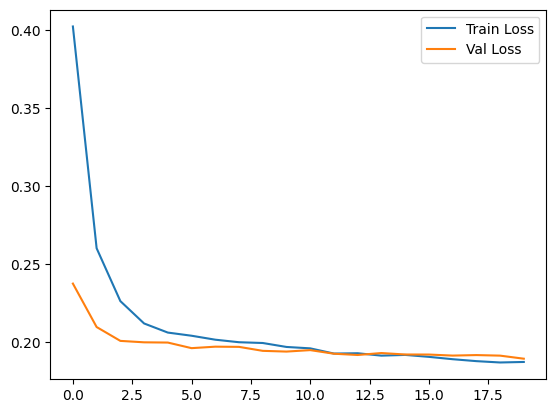

In [65]:
plt.plot(Nn.history['loss'], label='Train Loss')
plt.plot(Nn.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


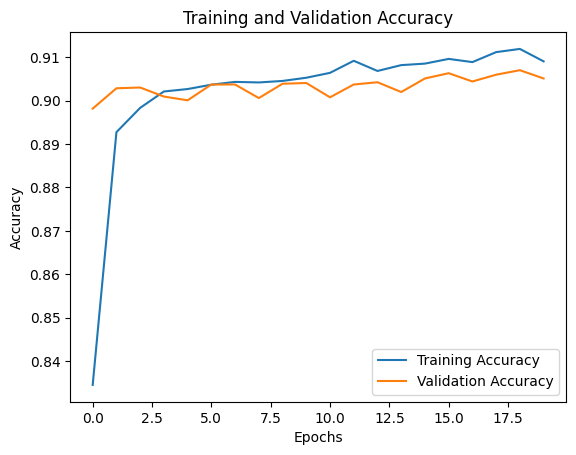

In [66]:
plt.plot(Nn.history['accuracy'], label='Training Accuracy')
plt.plot(Nn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **3. Model evaluation**

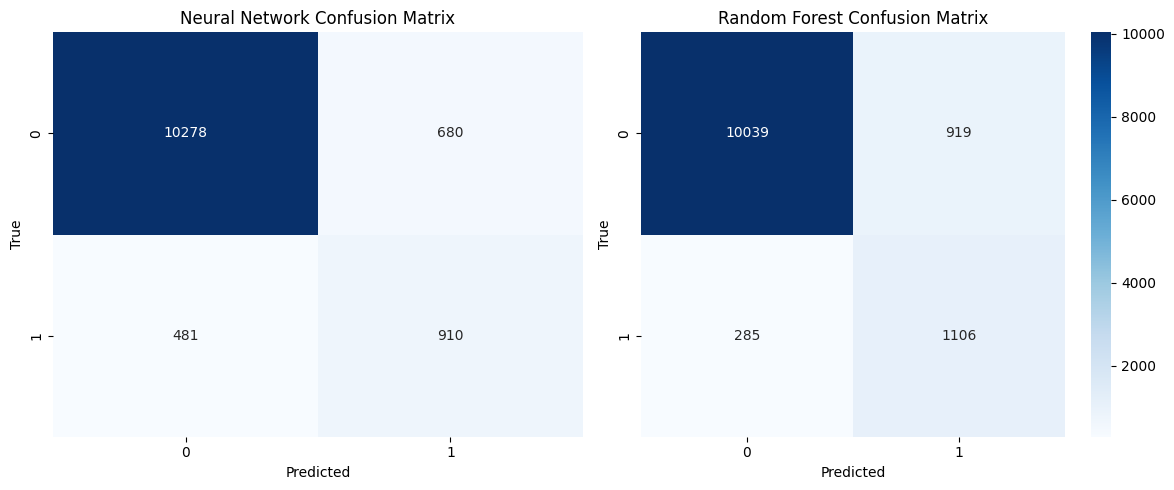

In [68]:
#confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_nn = confusion_matrix(y_test, y_pred_nn)
cm_rf = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()